In [2]:
suppressMessages(library(RMariaDB))
suppressMessages(library(dplyr))
suppressMessages(library(Matrix))
suppressMessages(library(data.table))
suppressMessages(library(tidyverse))
suppressMessages(library(GenomicRanges))
suppressMessages(library(rtracklayer))
suppressMessages(library(biomaRt))
suppressMessages(library(GenomicFeatures))
suppressMessages(library(RColorBrewer))
suppressMessages(library(conflicted))

Warning message:
“package ‘dplyr’ was built under R version 4.3.2”
Warning message:
“package ‘Matrix’ was built under R version 4.3.2”
Warning message:
“package ‘data.table’ was built under R version 4.3.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.2”
Warning message:
“package ‘readr’ was built under R version 4.3.2”
Warning message:
“package ‘stringr’ was built under R version 4.3.2”
Warning message:
“package ‘GenomicRanges’ was built under R version 4.3.3”
Warning message:
“package ‘BiocGenerics’ was built under R version 4.3.2”
Warning message:
“package ‘S4Vectors’ was built under R version 4.3.3”
Warning message:
“package ‘IRanges’ was built under R version 4.3.3”
Warning message:
“package ‘GenomeInfoDb’ was built under R version 4.3.2”
Warning message:
“package ‘Biobase’ was built under R version 4.3.3”


In [3]:
suppressMessages(conflicts_prefer(dplyr::filter))
suppressMessages(conflicts_prefer(dplyr::select))
suppressMessages(conflicts_prefer(dplyr::rename))
suppressMessages(conflicts_prefer(dplyr::lag))

# Load files

In [4]:
DE_exons_MOL2 = read.csv("/lustre/fs4/cao_lab/scratch/aliao/projects/EnrichSci/250112_Enrich_OLG/submission_files/final/DEE_MOL2.csv")

In [5]:
gtf_file <- "/ru-auth/local/home/asziraki/projects/AS_20200820_single_cell_pipeline/Raw_data/AS_20200820_genome_files/original_pipeline/Reference_ALL/index/GTF/mouse-latest-gencode-release-m27/gencode.vM27.primary_assembly.annotation.gtf.gz"
gtf <- rtracklayer::import(gtf_file)

In [6]:
# import exon gtf
exons <- rtracklayer::import("/ru-auth/local/home/asziraki/projects/AS_20200820_single_cell_pipeline/Raw_data/AS_20200820_genome_files/original_pipeline/Reference_ALL/index/GTF/mouse-latest-gencode-release-m27/gencode.vM27.primary_assembly.annotation.EXON.gtf.gz")

# Map MOL2 DEEs to Pfam domains

In [7]:
DEE_exons <- exons[mcols(exons)$gene_id %in% DE_exons_MOL2$exon_id]

In [8]:
DEE_table <- data.frame(
  gene_id = mcols(DEE_exons)$gene_id,
  chr = as.character(seqnames(DEE_exons)),
  start = start(DEE_exons),
  end = end(DEE_exons),
  strand = as.character(strand(DEE_exons))
)

In [9]:
DEE_table$gene_id_clean <- sapply(strsplit(DEE_table$gene_id, "-"), `[`, 1)
DEE_table$exon_id_clean <- sapply(strsplit(DEE_table$gene_id, "-"), `[`, 2)

# Remove version number
DEE_table$gene_id_fullyclean <- gsub("\\..*$", "", DEE_table$gene_id_clean)

In [10]:
#### map to protein

In [11]:
# Get all protein-coding transcripts and their Pfam domains
transcripts_domains <- getBM(
  attributes = c("ensembl_gene_id", "ensembl_transcript_id",
                 "transcript_biotype", "pfam", "pfam_start", "pfam_end"),
  mart = useMart("ensembl", dataset = "mmusculus_gene_ensembl")
)

In [12]:
# create GRanges object from DEE_table
DEE_gr <- GRanges(
  seqnames = DEE_table$chr,
  ranges = IRanges(start = DEE_table$start, end = DEE_table$end),
  strand = DEE_table$strand,
  exon_id = DEE_table$gene_id,
  gene_id = DEE_table$gene_id_clean
)

In [13]:
txdb <- makeTxDbFromGFF("/ru-auth/local/home/asziraki/projects/AS_20200820_single_cell_pipeline/Raw_data/AS_20200820_genome_files/original_pipeline/Reference_ALL/index/GTF/mouse-latest-gencode-release-m27/gencode.vM27.primary_assembly.annotation.gtf.gz", 
                        format = "gtf")

# Get coding sequences, grouped by transcript
cds_by_tx <- cdsBy(txdb, by="tx", use.names=TRUE)

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”
OK



In [14]:
cds_unlisted <- unlist(cds_by_tx, use.names = TRUE)
cds_txnames <- rep(names(cds_by_tx), elementNROWS(cds_by_tx))
mcols(cds_unlisted)$tx_id <- cds_txnames

In [15]:
overlaps <- findOverlaps(DEE_gr, cds_unlisted)

In [16]:
DEE_coords <- lapply(seq_along(overlaps), function(i) {
  
  dee_idx <- queryHits(overlaps)[i]   # index of DEE
  cds_idx <- subjectHits(overlaps)[i] # index of CDS of DEE (CDS-DEE)
  
  dee <- DEE_gr[dee_idx]        # genomic coordinates
  cds  <- cds_unlisted[cds_idx] # genomic coordinates
  tx_id <- mcols(cds)$tx_id # get transcript id for this CDS
  
  # also get all CDSs for this transcript 
  cds_tx <- cds_by_tx[[tx_id]]
  
  # Sort CDSs by genomic position; reverse if negative strand
  if(as.character(strand(cds_tx)[1]) == "+") {
    cds_tx <- sort(cds_tx)
  } else {
    cds_tx <- sort(cds_tx, decreasing = TRUE)
  }
  
  # Cumulative CDS start/end of the transcript
  cds_widths <- width(cds_tx)
  cds_cumend <- cumsum(cds_widths)
  cds_cumstart <- c(1, head(cds_cumend, -1))
  
  # Identify which CDS segment contains the CDS-DEE
  cds_exon_idx <- which(
    start(cds_tx) <= start(cds) & end(cds_tx) >= end(cds)
  )
  
  # Offset of CDS-DEE inside entire CDS
  offset_start <- max(start(dee) - start(cds) + 1, 1)
  offset_end   <- max(end(dee)   - start(cds) + 1, 1)
  
  # Add offset to get the absolute CDS coordinates
  cds_abs_start <- cds_cumstart[cds_exon_idx] + offset_start - 1
  cds_abs_end   <- cds_cumstart[cds_exon_idx] + offset_end   - 1
  
  # Convert to amino acids
  aa_start <- ceiling(cds_abs_start / 3)
  aa_end   <- ceiling(cds_abs_end / 3)
  
  data.frame(
    dee_id = mcols(dee)$exon_id,
    gene_id = mcols(dee)$gene_id,
    tx_id = tx_id,
    cds_abs_start = cds_abs_start,
    cds_abs_end = cds_abs_end,
    aa_start = aa_start,
    aa_end = aa_end
  )
})

prot_coords <- do.call(rbind, DEE_coords)

In [17]:
prot_coords$tx_id_clean <- gsub("\\..*$", "", prot_coords$tx_id)

In [18]:
# make GRanges object for DEEs in protein space
dee_protein_gr <- GRanges(
  seqnames = prot_coords$tx_id_clean,
  ranges = IRanges(start = prot_coords$aa_start, end = prot_coords$aa_end),
  dee_id = prot_coords$dee_id
)

In [19]:
transcripts_domains = transcripts_domains[ !is.na(transcripts_domains$pfam_start),]

In [20]:
# make GRanges object for Pfam domains 
pfam_gr <- GRanges(
  seqnames = transcripts_domains$ensembl_transcript_id,
  ranges = IRanges(
    start = transcripts_domains$pfam_start,
    end = transcripts_domains$pfam_end
  ),
  pfam = transcripts_domains$pfam
)

In [21]:
hits <- findOverlaps(dee_protein_gr, pfam_gr)

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': ENSMUST00000188782, ENSMUST00000188738, ENSMUST00000153561, ENSMUST00000028853, ENSMUST00000176141, ENSMUST00000127201, ENSMUST00000180164, ENSMUST00000160686, ENSMUST00000161512, ENSMUST00000155138, ENSMUST00000216893, ENSMUST00000111497, ENSMUST00000221014, ENSMUST00000023554, ENSMUST00000174417, ENSMUST00000222726, ENSMUST00000126432, ENSMUST00000236847, ENSMUST00000179505, ENSMUST00000178343
  - in 'y': ENSMUST00000082392, ENSMUST00000082396, ENSMUST00000082402, ENSMUST00000082405, ENSMUST00000082407, ENSMUST00000082408, ENSMUST00000082409, ENSMUST00000082411, ENSMUST00000084013, ENSMUST00000082414, ENSMUST00000082418, ENSMUST00000082419, ENSMUST00000082421, ENSMUST00000177783, ENSMUST00000179211, ENSMUST00000179715, ENSMUST00000177979, ENSMUST00000177562, ENSMUST00000178199, ENSMUST00000111364, ENSMUST00000178603, ENSMUST00000178309, ENSMUST0000011

In [22]:
# Build a data frame of DEE → Pfam overlaps
DEE_to_Pfam <- data.frame(
  dee_id = mcols(dee_protein_gr)$dee_id[queryHits(hits)],
  pfam   = mcols(pfam_gr)$pfam[subjectHits(hits)],
  stringsAsFactors = FALSE
)

# Aggregate Pfams per DEE
DEE_Pfam_summary <- DEE_to_Pfam %>%
  group_by(dee_id) %>%
  summarize(overlapping_pfams = paste(unique(pfam), collapse = ";"), 
            .groups = "drop")

In [23]:
DEE_table <- DEE_table %>%
  left_join(DEE_Pfam_summary, by = c("gene_id" = "dee_id"))

In [24]:
pfam_lines <- readLines("/ru-auth/local/home/aliao/scratch/projects/EnrichSci/datasets/pfam/Pfam-A.hmm.gz")

In [25]:
acc_lines <- grep("^ACC", pfam_lines, value = TRUE)
desc_lines <- grep("^DESC", pfam_lines, value = TRUE)

pfam_df <- data.frame(
  PfamID = sub("^ACC\\s+", "", acc_lines),
  Description = sub("^DESC\\s+", "", desc_lines),
  stringsAsFactors = FALSE
)

In [26]:
pfam_df$PfamID_clean <- gsub("\\..*$", "", pfam_df$PfamID)

In [27]:
dee_2_annot <- DEE_table %>%
  dplyr::select(gene_id, overlapping_pfams) %>%
  separate_rows(overlapping_pfams, sep = ";") %>%   # expand into multiple rows
  left_join(pfam_df, by = c("overlapping_pfams" = "PfamID_clean")) %>%
  group_by(gene_id) %>%
  summarise(
    overlapping_pfams = paste(unique(overlapping_pfams), collapse = ";"),
    PfamID            = paste(unique(PfamID), collapse = ";"),
    Description       = paste(unique(Description), collapse = ";"),
    .groups = "drop"
  )
dee_2_annot$exon_id = dee_2_annot$gene_id

DEE_2_annot <- dee_2_annot %>%
  dplyr::select(exon_id, overlapping_pfams, PfamID, Description) %>%
  right_join(DE_exons_MOL2, by = "exon_id") %>%
  dplyr::select(gene_short_name, everything())

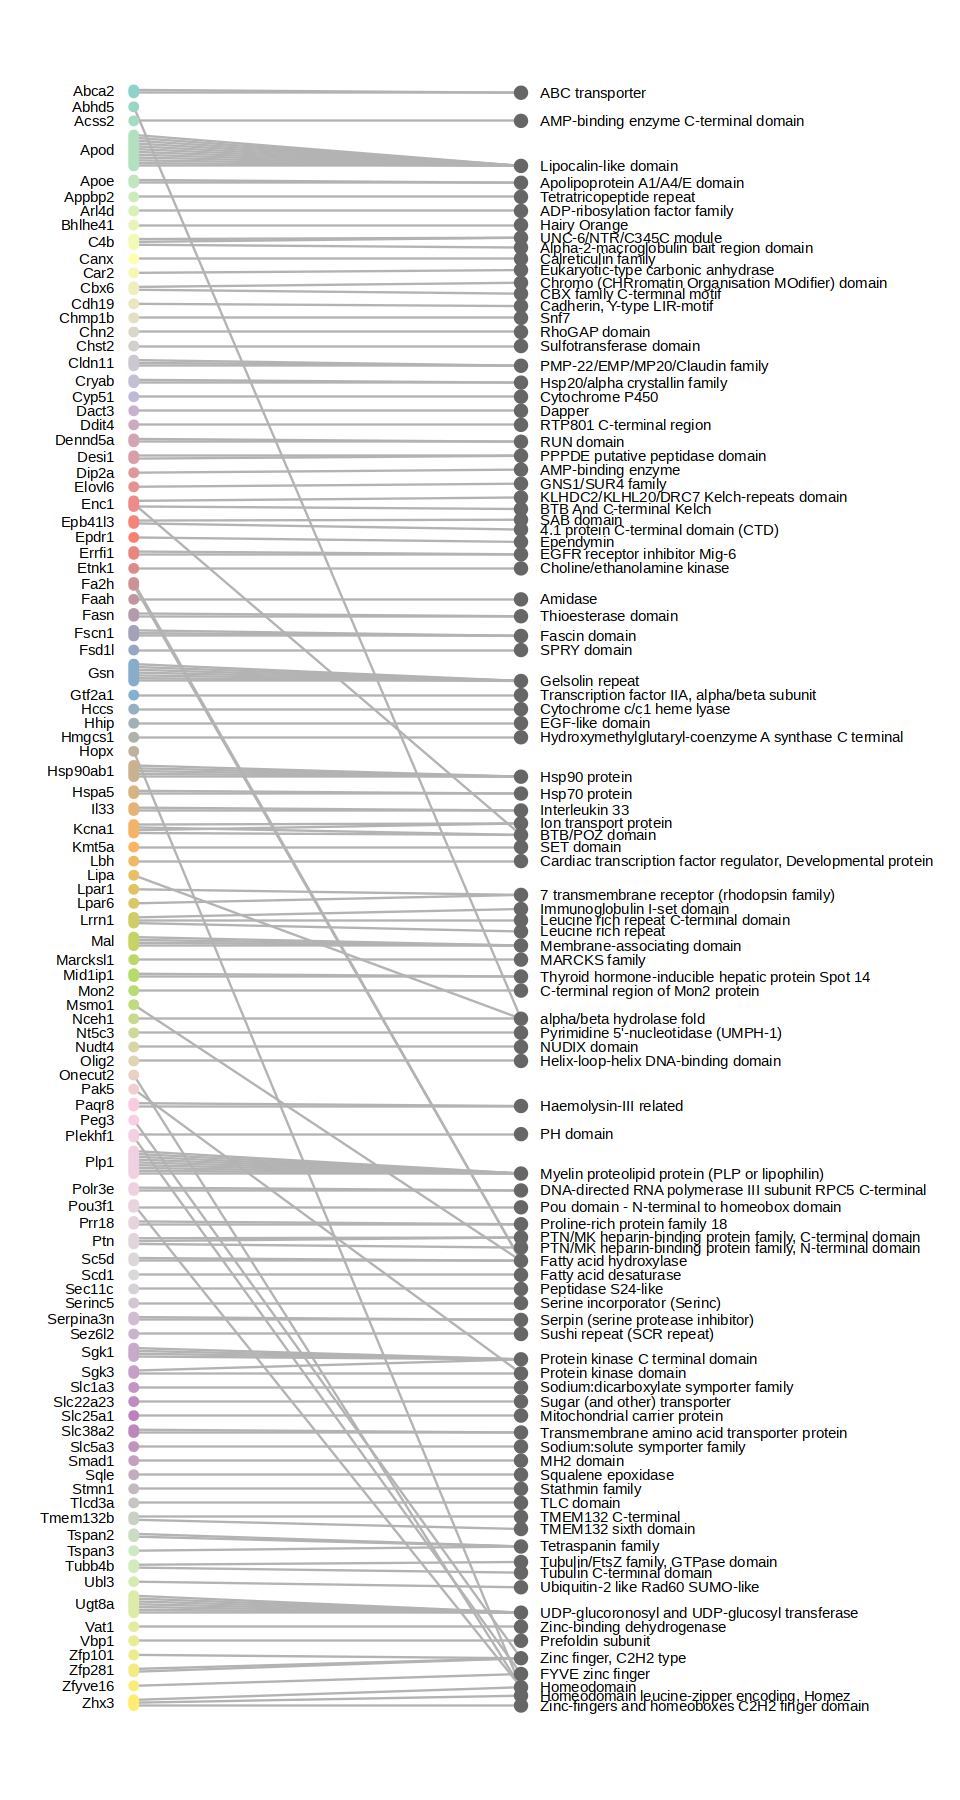

In [28]:
## Bipartite plot for DEE-Pfam mapping
### note that one DEE point is plotted for each DEE-Pfam mapping; this is an issue if a DEE maps to multiple Pfams
### for each DEE that maps to multiple Pfams, we manually changed its points to a single point in Adobe Illustrator 

options(repr.plot.width = 8, repr.plot.height = 15)

# 1. Remove redundant annotations and filter out exons with no domain
DEE_2_annot$Description =ifelse(DEE_2_annot$Description == 'C2H2-type zinc finger;Zinc finger, C2H2 type', 'Zinc finger, C2H2 type', DEE_2_annot$Description)
df <- DEE_2_annot %>%
  filter(Description != 'NA') %>%
  separate_rows(Description, sep = ";") %>%   # expand multiple domains
  mutate(domain_group = Description)

# 2. Group domains by full Description or simplified family name if desired
df <- df %>% mutate(domain_group = Description)

# If needed for clearer plotting, swap order of exons for a gene
    #Identify the indices of C4b rows in the dataframe
    c4b_idx <- which(df$gene_short_name == "C4b")
    # Create a new order for the C4b rows
    new_order <- c(1, 3, 2) 
    df[c4b_idx, ] <- df[c4b_idx[new_order], ]

# 3. Assign y positions to exons, grouped by gene
df <- df %>%
  arrange(gene_short_name) %>%
  group_by(gene_short_name) %>%
  mutate(exon_y = row_number()) %>%
  ungroup()

# Add cumulative offsets for gaps between genes
gene_offsets <- df %>%
  group_by(gene_short_name) %>%
  summarise(max_exon = max(exon_y)) %>%
  arrange(desc(gene_short_name)) %>%  # reverse gene order
  mutate(offset = cumsum(lag(max_exon + 4, default = 0)))

df <- df %>%
  left_join(gene_offsets %>% select(gene_short_name, offset), by = "gene_short_name") %>%
  mutate(y_exon = exon_y + offset)

# 4. Assign y positions to domains based on connected exons
domain_groups <- df %>%
  group_by(domain_group) %>%
  summarise(y_domain = min(y_exon))  # or max(y_exon)

# To prevent overlaps for clearer plotting, manually adjust y positions
domain_groups$y_domain[domain_groups$domain_group == "UNC-6/NTR/C345C module"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "UNC-6/NTR/C345C module"] + 1.5
domain_groups$y_domain[domain_groups$domain_group == "Alpha-2-macroglobulin bait region domain"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "Alpha-2-macroglobulin bait region domain"] -1

domain_groups$y_domain[domain_groups$domain_group == "PTN/MK heparin-binding protein family, C-terminal domain"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "PTN/MK heparin-binding protein family, C-terminal domain"] +1.3
domain_groups$y_domain[domain_groups$domain_group == "PTN/MK heparin-binding protein family, N-terminal domain"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "PTN/MK heparin-binding protein family, N-terminal domain"] -1.3

domain_groups$y_domain[domain_groups$domain_group == "Eukaryotic-type carbonic anhydrase"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "Eukaryotic-type carbonic anhydrase"] +1

domain_groups$y_domain[domain_groups$domain_group == "CBX family C-terminal motif"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "CBX family C-terminal motif"] -1.4
domain_groups$y_domain[domain_groups$domain_group == "Chromo (CHRromatin Organisation MOdifier) domain"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "Chromo (CHRromatin Organisation MOdifier) domain"] +1.5
domain_groups$y_domain[domain_groups$domain_group == "BTB And C-terminal Kelch"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "BTB And C-terminal Kelch"] -0.9
domain_groups$y_domain[domain_groups$domain_group == "KLHDC2/KLHL20/DRC7 Kelch-repeats domain"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "KLHDC2/KLHL20/DRC7 Kelch-repeats domain"] +1.2
domain_groups$y_domain[domain_groups$domain_group == "PPPDE putative peptidase domain"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "PPPDE putative peptidase domain"] +1
domain_groups$y_domain[domain_groups$domain_group == "AMP-binding enzyme"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "AMP-binding enzyme"] +1.1
domain_groups$y_domain[domain_groups$domain_group == "GNS1/SUR4 family"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "GNS1/SUR4 family"] +1.1
domain_groups$y_domain[domain_groups$domain_group == "4.1 protein C-terminal domain (CTD)"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "4.1 protein C-terminal domain (CTD)"] -2.2
domain_groups$y_domain[domain_groups$domain_group == "SAB domain"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "SAB domain"] +0.3
domain_groups$y_domain[domain_groups$domain_group == "Ependymin"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "Ependymin"] -1.6
domain_groups$y_domain[domain_groups$domain_group == "Cadherin, Y-type LIR-motif"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "Cadherin, Y-type LIR-motif"] -0.8
domain_groups$y_domain[domain_groups$domain_group == "Ion transport protein"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "Ion transport protein"] +2.4
domain_groups$y_domain[domain_groups$domain_group == "BTB/POZ domain"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "BTB/POZ domain"] -0.7
domain_groups$y_domain[domain_groups$domain_group == "Leucine rich repeat"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "Leucine rich repeat"] -3
domain_groups$y_domain[domain_groups$domain_group == "Immunoglobulin I-set domain"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "Immunoglobulin I-set domain"] +3
domain_groups$y_domain[domain_groups$domain_group == "7 transmembrane receptor (rhodopsin family)"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "7 transmembrane receptor (rhodopsin family)"] +3
domain_groups$y_domain[domain_groups$domain_group == "Leucine rich repeat C terminal domain"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "Leucine rich repeat C terminal domain"] -2.3
domain_groups$y_domain[domain_groups$domain_group == "Zinc finger, C2H2 type"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "Zinc finger, C2H2 type"] +4.8
domain_groups$y_domain[domain_groups$domain_group == "FYVE zinc finger"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "FYVE zinc finger"] + 4.2
domain_groups$y_domain[domain_groups$domain_group == "Homeodomain"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "Homeodomain"] +4.5
domain_groups$y_domain[domain_groups$domain_group == "Homeodomain leucine-zipper encoding, Homez"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "Homeodomain leucine-zipper encoding, Homez"] +2.5
domain_groups$y_domain[domain_groups$domain_group == "Protein kinase C terminal domain"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "Protein kinase C terminal domain"] + 4
domain_groups$y_domain[domain_groups$domain_group == "TMEM132 sixth domain"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "TMEM132 sixth domain"] -3.3
domain_groups$y_domain[domain_groups$domain_group == "Tetraspanin family"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "Tetraspanin family"] + 1.5
domain_groups$y_domain[domain_groups$domain_group == "Tubulin/FtsZ family, GTPase domain"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "Tubulin/FtsZ family, GTPase domain"] +1
domain_groups$y_domain[domain_groups$domain_group == "Tubulin C-terminal domain"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "Tubulin C-terminal domain"] -1.8
domain_groups$y_domain[domain_groups$domain_group == "Ubiquitin-2 like Rad60 SUMO-like"] <- 
  domain_groups$y_domain[domain_groups$domain_group == "Ubiquitin-2 like Rad60 SUMO-like"] -2


# 5. Merge back domain y positions to edges
df <- df %>% left_join(domain_groups, by = "domain_group")

edges <- df %>%
  mutate(x_start = 0, x_end = 1,
         y_start = y_exon, y_end = y_domain) %>%
  select(x_start, y_start, x_end, y_end)

# 6. Assign gene colors
gene_colors <- setNames(colorRampPalette(brewer.pal(12, "Set3"))(length(unique(df$gene_short_name))),
                        unique(df$gene_short_name))

# 7. Plot
ggplot() +
  # edges
  geom_segment(data = edges, aes(x = x_start, y = y_start, xend = x_end, yend = y_end), color = "gray70") +
  # exons
  geom_point(data = df, aes(x = 0, y = y_exon, color = gene_short_name), size = 2) +
  # gene labels
  geom_text(data = df %>% group_by(gene_short_name) %>% summarise(y_mid = mean(y_exon)), 
            aes(x = -0.05, y = y_mid, label = gene_short_name),
            hjust = 1, size = 3) +
  # domains
  geom_point(data = domain_groups, aes(x = 1, y = y_domain), color = "gray40", size = 3) +
  geom_text(data = domain_groups, aes(x = 1, y = y_domain, label = domain_group),
            hjust = 0, nudge_x = 0.05, size = 3) +

  scale_color_manual(values = gene_colors) +
  theme_minimal() +
  theme(
    axis.text = element_blank(),
    axis.title = element_blank(),
    legend.position = "none",
    panel.grid = element_blank()
  ) +
  xlim(c(-0.2, 2))